In [24]:
# required packages here
library("ggplot2")
# library(randomcoloR)

In [2]:
data <- read.csv("hotel_bookings.csv")
dim(data)

[1] 119390     32

In [3]:
head(data)

hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03
Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03


In [4]:
str(data)

'data.frame':	119390 obs. of  32 variables:
 $ hotel                         : Factor w/ 2 levels "City Hotel","Resort Hotel": 2 2 2 2 2 2 2 2 2 2 ...
 $ is_canceled                   : int  0 0 0 0 0 0 0 0 1 1 ...
 $ lead_time                     : int  342 737 7 13 14 14 0 9 85 75 ...
 $ arrival_date_year             : int  2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 ...
 $ arrival_date_month            : Factor w/ 12 levels "April","August",..: 6 6 6 6 6 6 6 6 6 6 ...
 $ arrival_date_week_number      : int  27 27 27 27 27 27 27 27 27 27 ...
 $ arrival_date_day_of_month     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ stays_in_weekend_nights       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : int  0 0 1 1 2 2 2 2 3 3 ...
 $ adults                        : int  2 2 1 1 2 2 2 2 2 2 ...
 $ children                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : Factor w/ 5 levels "BB","

In [5]:
purple <- "#8300fd"
red <- "#c12525"
colors <- c(purple, red)

# Data Preprocessing

In [6]:
colSums(is.na(data) | data == "NULL")

hotel                    is_canceled 
                             0                              0 
                     lead_time              arrival_date_year 
                             0                              0 
            arrival_date_month       arrival_date_week_number 
                             0                              0 
     arrival_date_day_of_month        stays_in_weekend_nights 
                             0                              0 
          stays_in_week_nights                         adults 
                             0                              0 
                      children                         babies 
                             4                              0 
                          meal                        country 
                             0                            488 
                market_segment           distribution_channel 
                             0                              0 
             is_repeated_guest         previous_cancellations 
                             0                              0 
previous_bookings_not_canceled             reserved_room_type 
                             0                              0 
            assigned_room_type                booking_changes 
                             0                              0 
                  deposit_type                          agent 
                             0                          16340 
                       company           days_in_waiting_list 
                        112593                              0 
                 customer_type                            adr 
                             0                              0 
   required_car_parking_spaces      total_of_special_requests 
                             0                              0 
            reservation_status        reservation_status_date 
                             0                              0

In [7]:
data$children[is.na(data$children)] = 0

levels(data$country) <- c(levels(data$country), "UNKNOWN") 
data$country[data$country == "NULL"] <- "UNKNOWN"

levels(data$agent) <- c(levels(data$agent), '0')
data$agent[data$agent == "NULL"] <- '0'

levels(data$company) <- c(levels(data$company), '0')
data$company[data$company == "NULL"] <- '0'

In [8]:
colSums(is.na(data) | data == "NULL")

hotel                    is_canceled 
                             0                              0 
                     lead_time              arrival_date_year 
                             0                              0 
            arrival_date_month       arrival_date_week_number 
                             0                              0 
     arrival_date_day_of_month        stays_in_weekend_nights 
                             0                              0 
          stays_in_week_nights                         adults 
                             0                              0 
                      children                         babies 
                             0                              0 
                          meal                        country 
                             0                              0 
                market_segment           distribution_channel 
                             0                              0 
             is_repeated_guest         previous_cancellations 
                             0                              0 
previous_bookings_not_canceled             reserved_room_type 
                             0                              0 
            assigned_room_type                booking_changes 
                             0                              0 
                  deposit_type                          agent 
                             0                              0 
                       company           days_in_waiting_list 
                             0                              0 
                 customer_type                            adr 
                             0                              0 
   required_car_parking_spaces      total_of_special_requests 
                             0                              0 
            reservation_status        reservation_status_date 
                             0                              0

In [9]:
data = data[data$adults + data$children + data$babies > 0,]
data = data[data$stays_in_weekend_nights + data$stays_in_week_nights > 0,]
dim(data)

[1] 118565     32

# Data Visualization

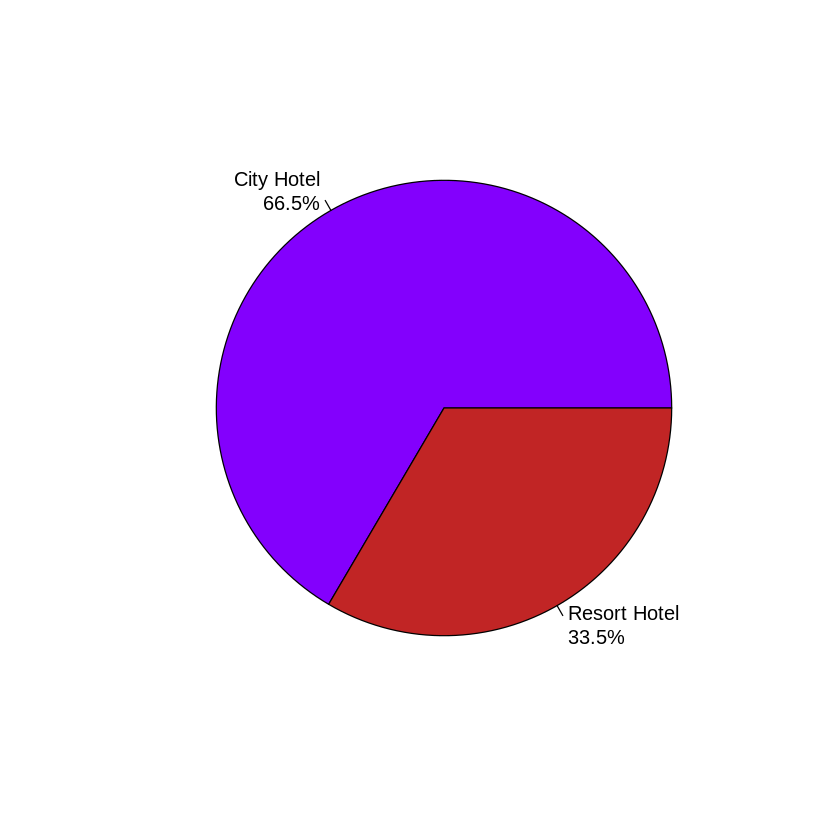

In [10]:
hotel <- table(data$hotel)
hotel_types <- c("City Hotel", "Resort Hotel")

pie_percent<- paste(hotel_types, round(100*hotel/sum(hotel), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(hotel, labels=pie_percent, col = colors)

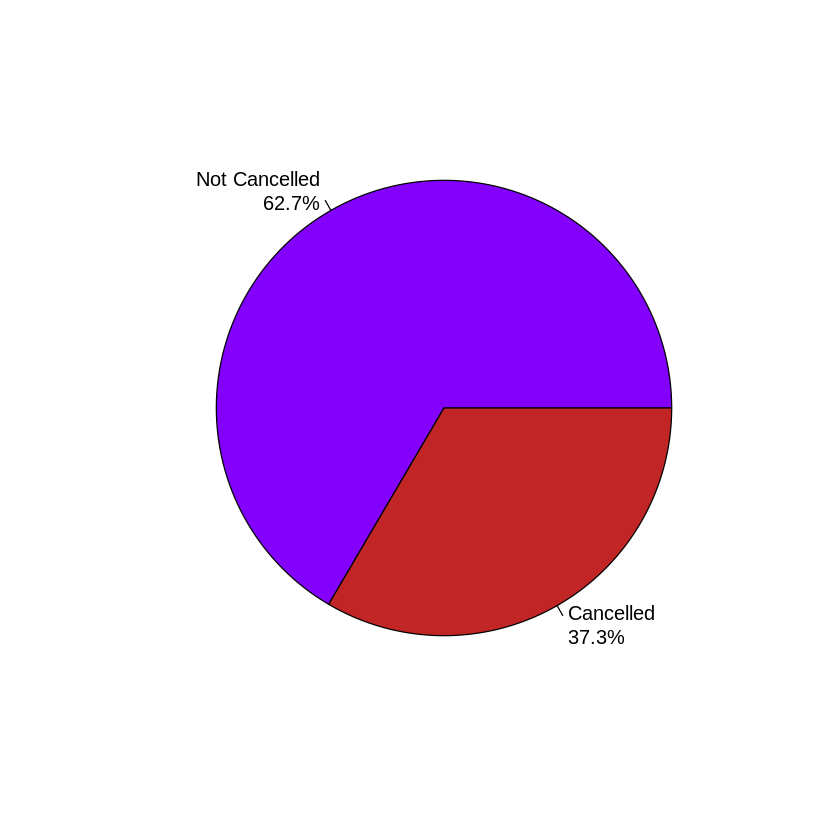

In [11]:
cancel <- table(data$is_canceled)
cancel_label <- c("Not Cancelled", "Cancelled")

pie_percent<- paste(cancel_label, round(100*cancel/sum(cancel), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(hotel, labels=pie_percent, col = colors)

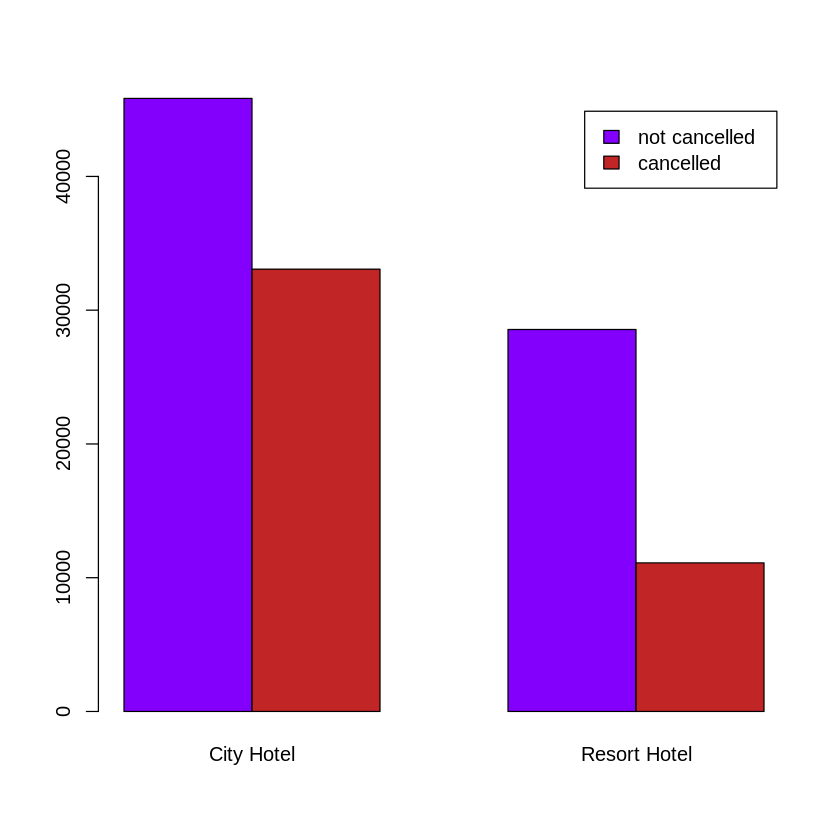

In [27]:
labels <- c("not cancelled", "cancelled")

hotel_cancel <- t(table(data$hotel, data$is_canceled))

barplot(hotel_cancel, beside = T, legend.text = labels, col = colors)

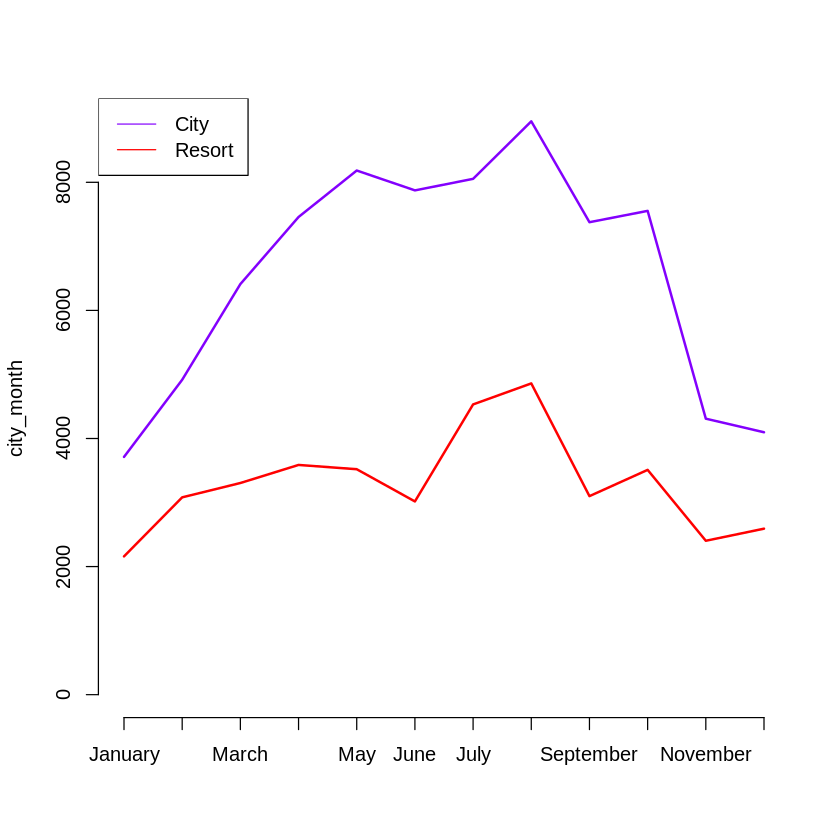

In [13]:
hotel_month <- table(data$hotel, data$arrival_date_month)

months = c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")

city_month = table(factor(data[data$hotel=='City Hotel',]$arrival_date_month, levels = months))
resort_month = table(factor(data[data$hotel=='Resort Hotel',]$arrival_date_month, levels = months))

plot(city_month, type="l", col = "#8300fd")
lines(resort_month, col = "red", type="l")
legend("topleft", legend=c("City", "Resort"),
       col=c("#8300fd", "red"), lty=c(1,1))

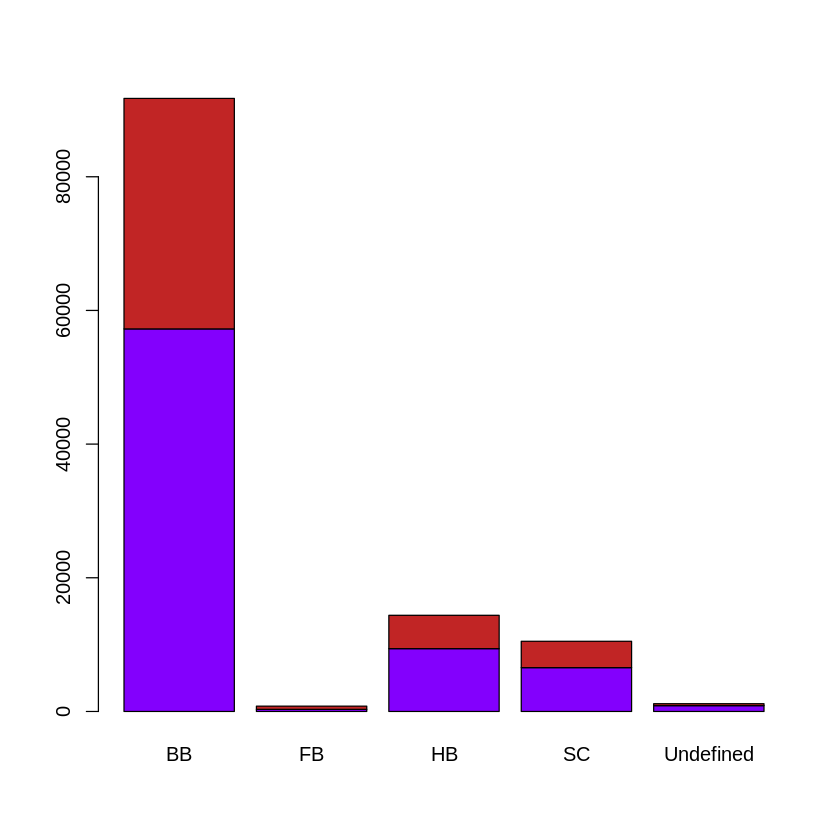

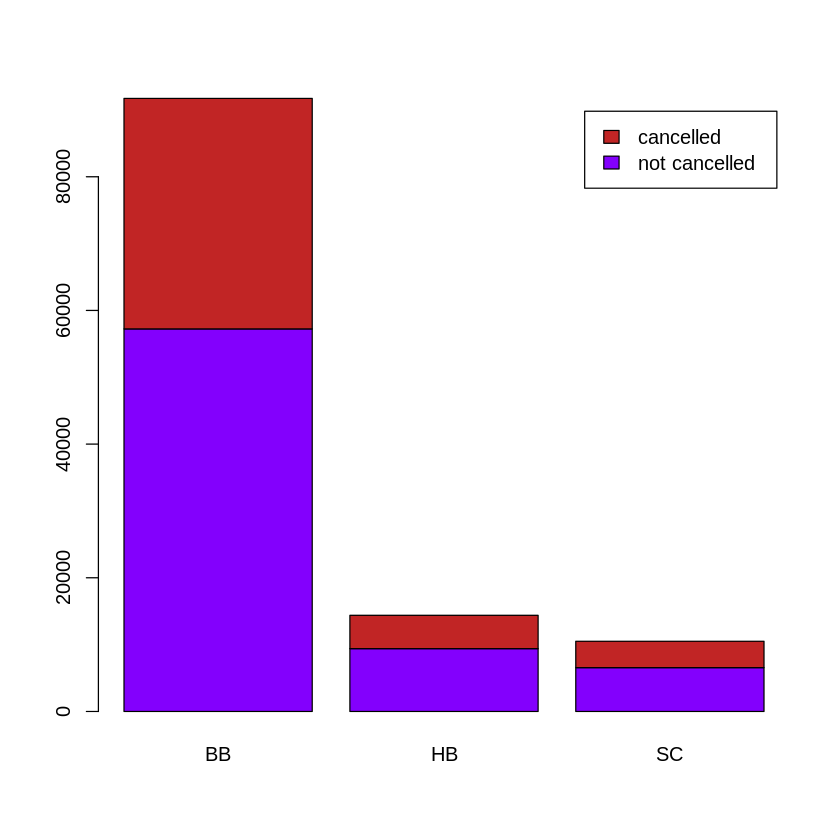

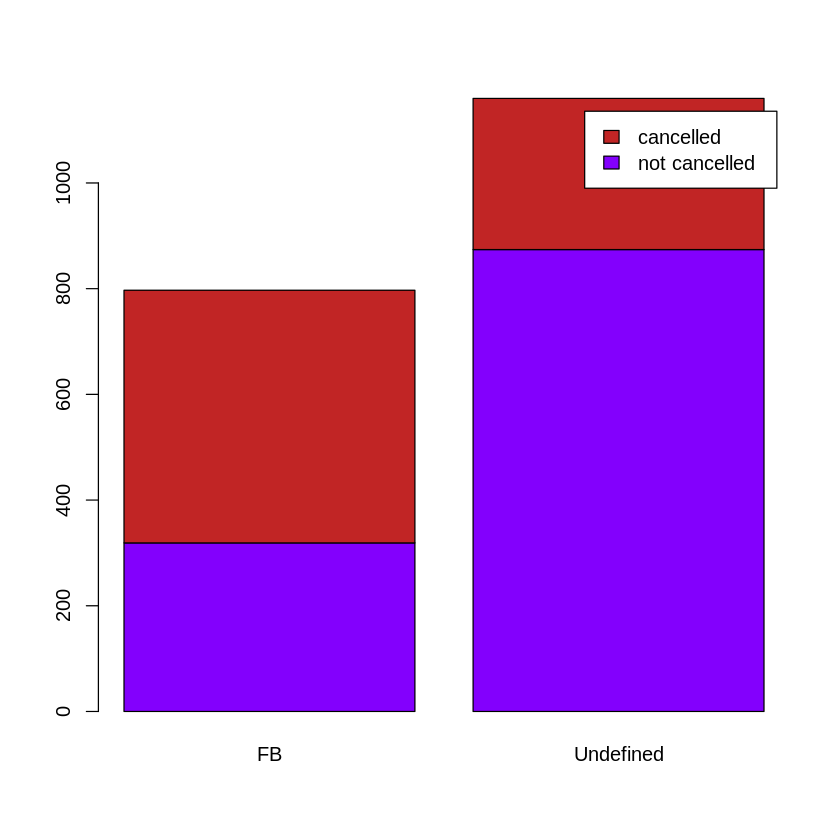

In [14]:
mean_cancel <- t(table(data$meal, data$is_canceled))

barplot(mean_cancel, col=colors)
barplot(mean_cancel[, -c(2, 5)], legend.text = labels, col=colors)
barplot(mean_cancel[, c(2, 5)], legend.text = labels, col=colors)

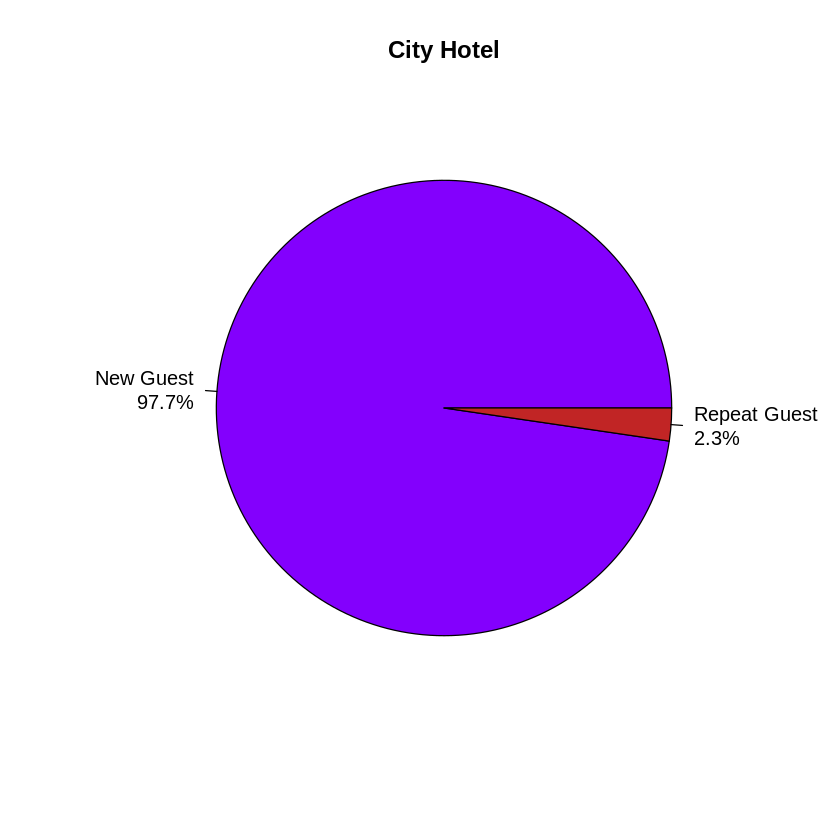

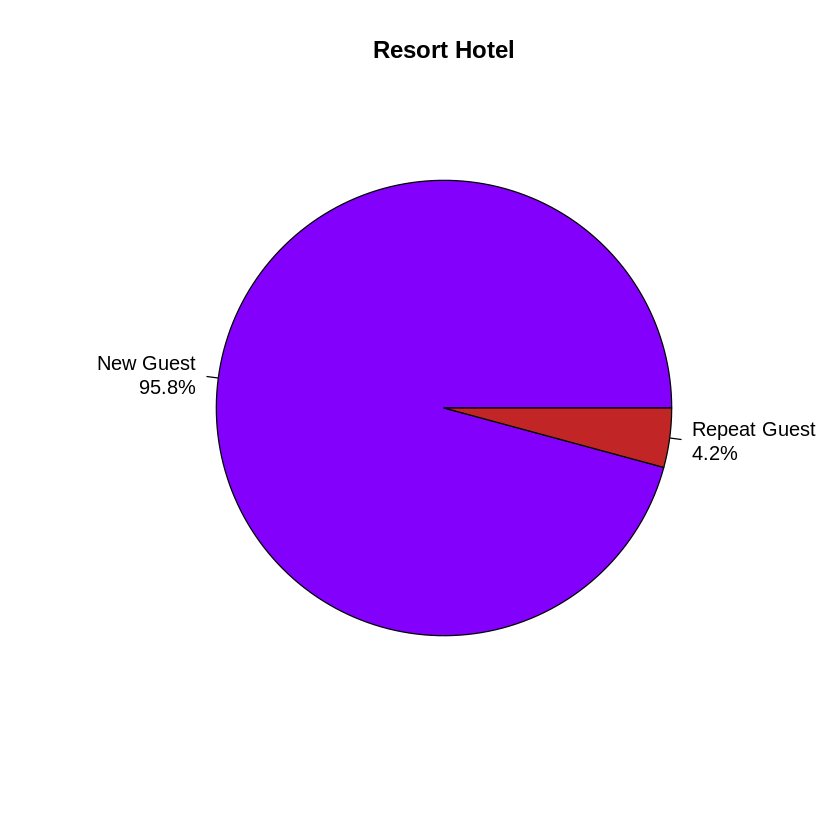

In [15]:
hotel_repeted <- table(data$is_repeated_guest, data$hotel)

repeat_city <- table(data[data$hotel == "City Hotel",]$is_repeated_guest)
repeat_resort <- table(data[data$hotel == "Resort Hotel",]$is_repeated_guest)

repeat_labels <- c("New Guest","Repeat Guest")

pie_percent<- paste(repeat_labels, round(100*repeat_city/sum(repeat_city), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(repeat_city, labels=pie_percent, main = "City Hotel", col = colors)

pie_percent<- paste(repeat_labels, round(100*repeat_resort/sum(repeat_resort), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(repeat_resort, labels=pie_percent, main = "Resort Hotel", col = colors)

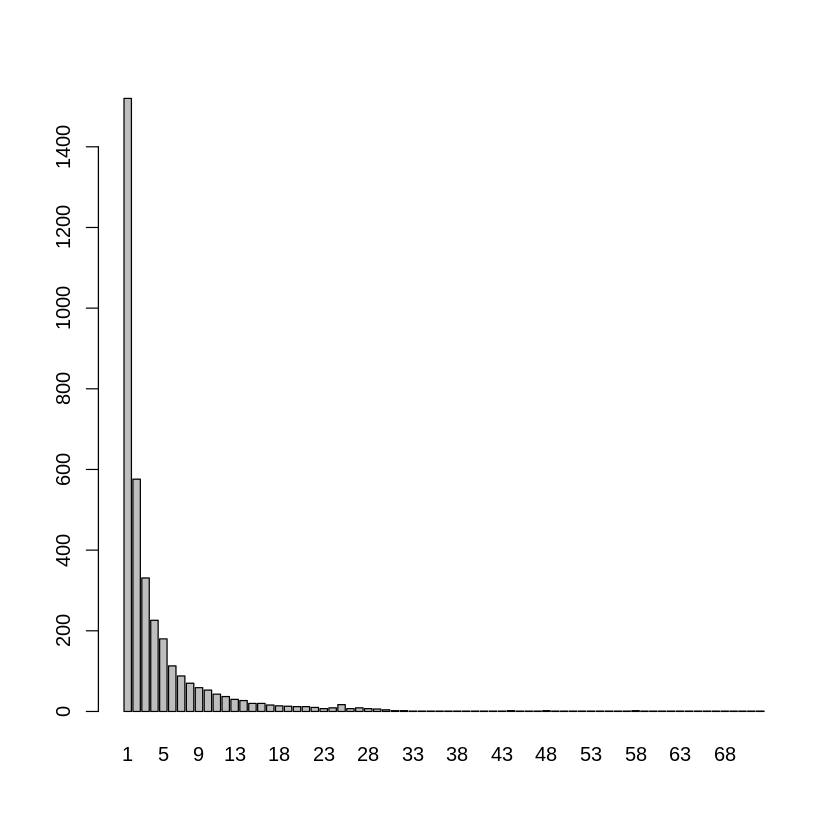

In [16]:
barplot(table(data$previous_bookings_not_canceled)[-1])

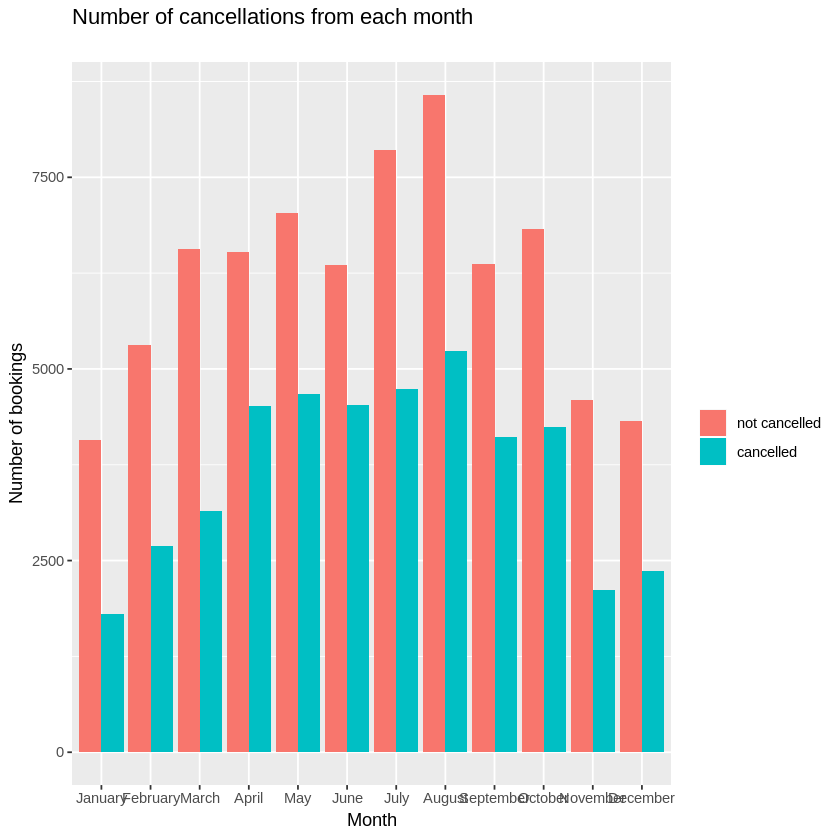

In [17]:
month_cancel <- table(data$is_canceled, data$arrival_date_month)

g <- ggplot(data, aes(x = factor(arrival_date_month, levels = months) , fill = factor(is_canceled)))

g + geom_bar(position = position_dodge()) + 
labs(title = "Number of cancellations from each month\n", x = "Month", y = "Number of bookings")+
scale_fill_discrete(name="", labels=labels)


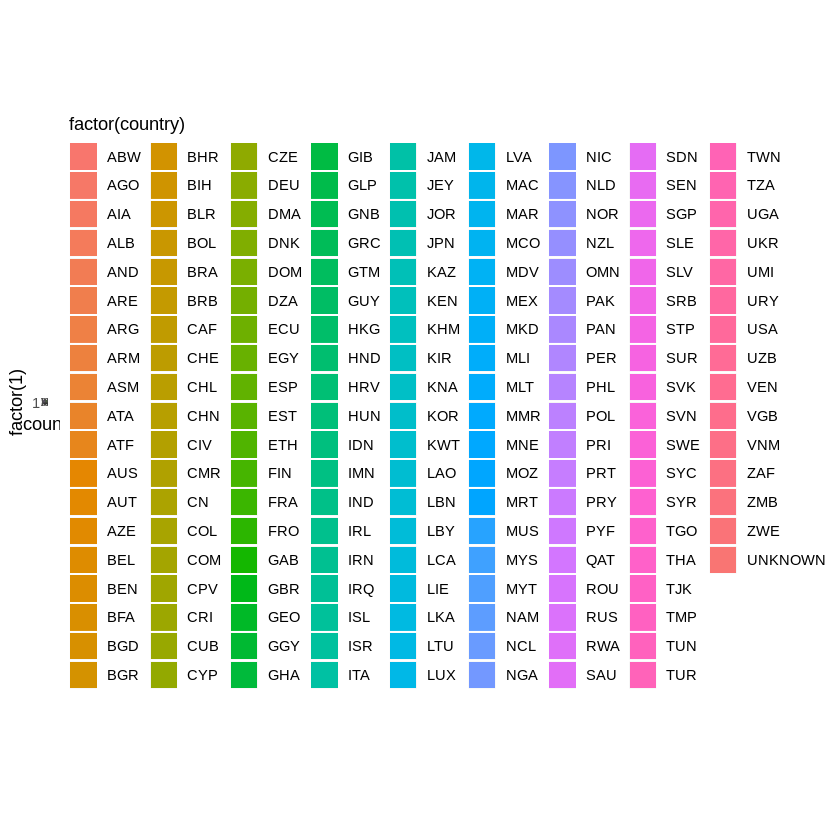

In [18]:
ggplot(data[data$hotel=="City Hotel",], aes(x = factor(1), fill= factor(country))) +
geom_bar(width = 1) +
coord_polar(theta = "y")

In [19]:
# color = grDevices::colors()[grep('gr(a|e)y', grDevices::colors(), invert = T)]
# cols <- sample(color, 178)

# country_city <- as.data.frame(country_city)

# ggplot(country_city, aes(x = "", y = sort(Freq), colour=Var1, fill= Var1))+
#  geom_col(color = "transparent", width = NULL) +
#   scale_fill_manual(values = sample(color, 178))+
#   coord_polar("y", start = 0) +
#   theme_void()

  USA   NLD   BRA   BEL   IRL   ITA   DEU   ESP   FRA   GBR   PRT OTHER 
 2089  2101  2217  2338  3373  3756  7285  8544 10389 12095 47943 16435 


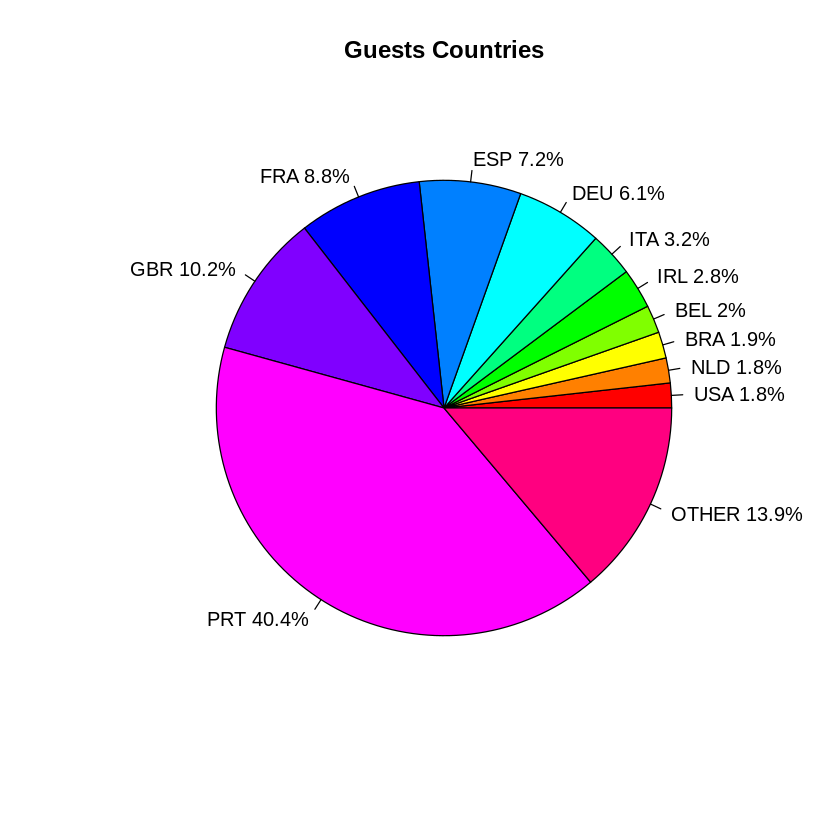

In [20]:
th = 2000
countries = table(data$country)
filtered_countries = countries[countries > th]
filtered_countries = sort(filtered_countries)
filtered_countries["OTHER"] = sum(countries[countries < th])
print(filtered_countries)

labels = names(filtered_countries)

pie_percent<- paste(labels, round(100*filtered_countries/sum(filtered_countries), 1), sep=" ") 
pie_percent<- paste(pie_percent, "%", sep="")

pie(filtered_countries, main = "Guests Countries", labels=pie_percent, col = rainbow(length(filtered_countries)))

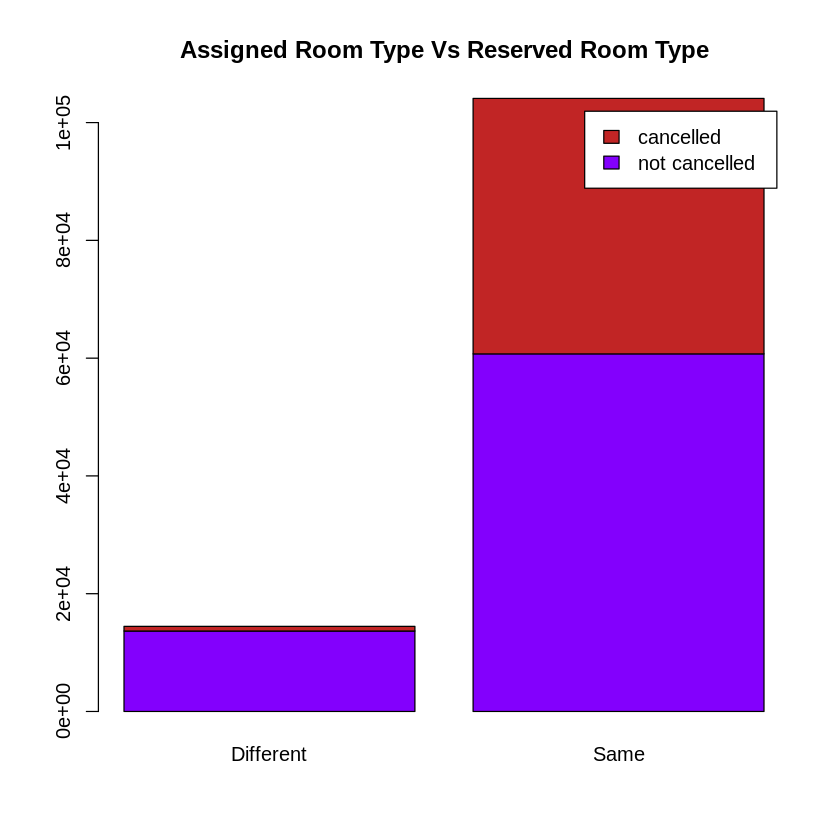

In [21]:
room_types = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "K","L", "P")
f1 = factor(data$assigned_room_type, levels = room_types)
f2 = factor(data$reserved_room_type, levels = room_types)


labels <- c("not cancelled", "cancelled")

room_cancel <- table(f1 == f2, data$is_canceled)
rownames(room_cancel) = c("Different", "Same")
room_cancel <- t(room_cancel)

barplot(room_cancel, main = "Assigned Room Type Vs Reserved Room Type",legend.text = labels, col = colors)

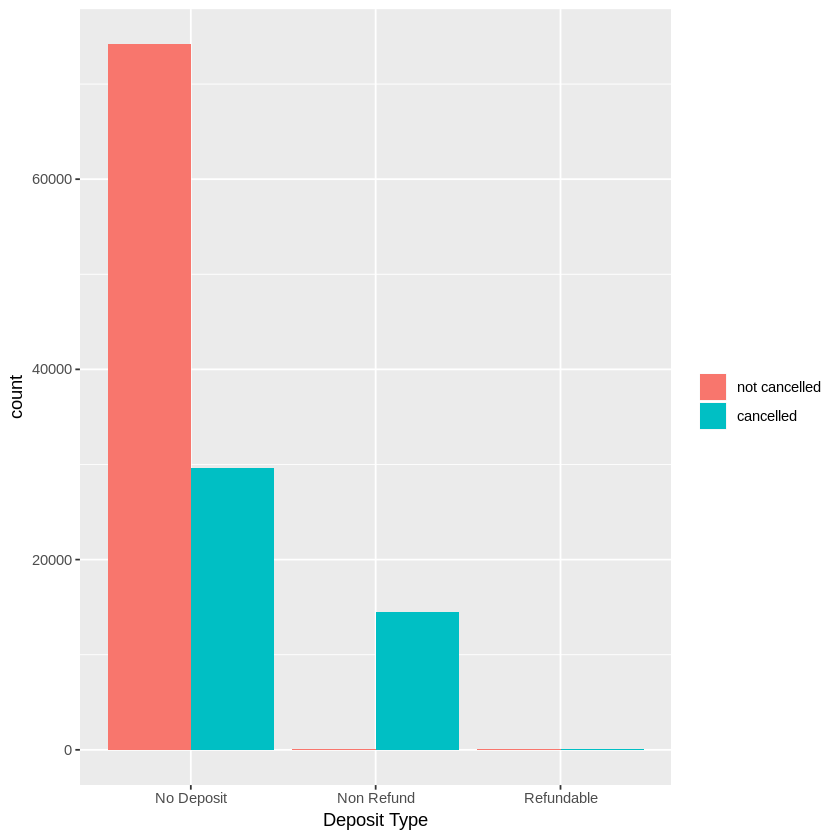

In [22]:
ggplot(data, aes(x = deposit_type, fill=factor(is_canceled))) + 
geom_bar(position = position_dodge()) +
labs(x="Deposit Type") + 
scale_fill_discrete(name = NULL, labels = c("not cancelled", "cancelled"))

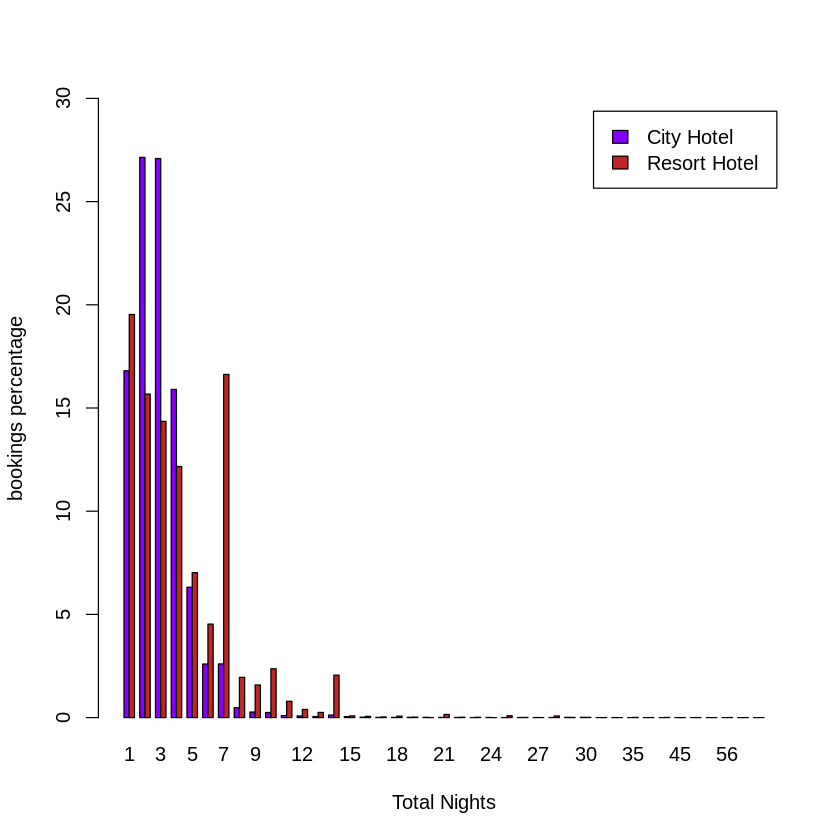

In [23]:
labels <- c("City Hotel", "Resort Hotel")


total_nights = data$stays_in_weekend_nights + data$stays_in_week_nights
hotel_nights = prop.table(table(total_nights, data$hotel), margin=2)*100
hotel_nights = t(hotel_nights)

barplot(hotel_nights, beside = T, ylim = c(0,30), xlab = 'Total Nights', ylab = 'bookings percentage', legend.text = labels, col = colors)